## Introduction

In this notebook, we are going through a famous dataset called fashionMNIST which comprises 60k pictures with 28*28 pixels in the train set, and 10k in the test set. We are going to use a simple neural network(NOT convolution) for this problem and we will get 89% accuracy.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'The device is: {device}')

The device is: cuda


In [4]:
Train_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/fashion-mnist_train.csv')
test_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/fashion-mnist_test.csv')

In [5]:
Train_set

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This is our Labels:

0: T-shirt/top,
1: Trouser,
2: Pullover,
3: Dress,
4: Coat,
5: Sandal,
6: Shirt,
7: Sneaker,
8: Bag,
9: Ankle boot,

## Visualizing Data

Let's see some of examples of our dataset

In [6]:
def mapping_labels(label):
    my_dict = {
        0 : 'T-shirt/top',
        1 : 'Trouser',
        2 : 'Pullover',
        3 : 'Dress',
        4 : 'Coat',
        5 : 'Sandal',
        6 : 'Shirt',
        7 : 'Sneaker',
        8 : 'Bag',
        9 : 'Ankle boot'
    }
    return my_dict.get(label)


In [7]:
example = Train_set.sample(n = 15)
labels = np.array(example.label)
example.drop(['label'],axis = 1 , inplace = True)
example = np.array(example).reshape(-1, 28, 28)

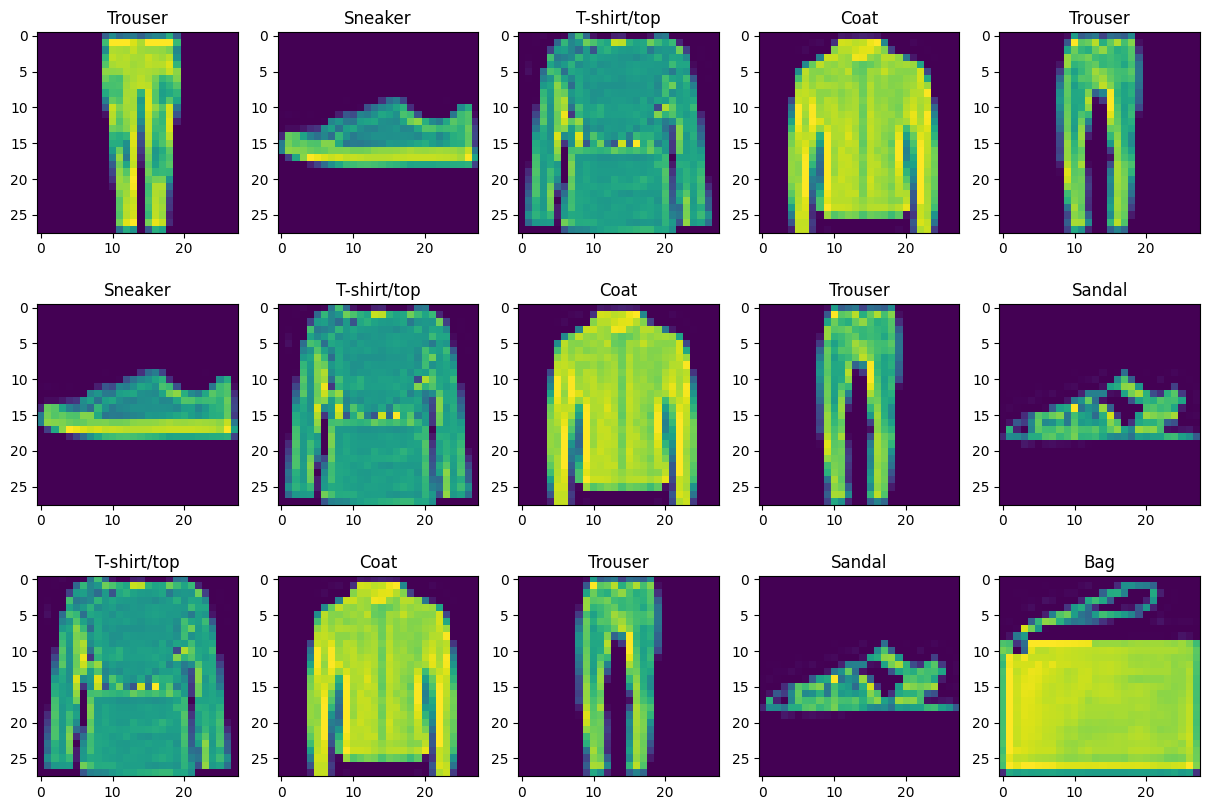

In [8]:
fig, ax = plt.subplots(nrows = 3, ncols = 5, figsize = (15,10))
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(example[i+j])
        ax[i,j].set_title(mapping_labels(labels[i+j]))

plt.show()

## Prepare Data to fit in our Neural Network

In [9]:
y_train = np.array(Train_set.label)
x_train = np.array(Train_set.drop(['label'],axis = 1))
y_test = np.array(test_set.label)
x_test = np.array(test_set.drop(['label'],axis = 1))

We want 3 separate sets, a train set that the model can learn based on that, a dev set that after each epoch we can evaluate model performance, and a test set that is unseen from the model to evaluate model performance after completing the learning process.

In [10]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.16, random_state = 40)

In [11]:
y_train = torch.tensor(y_train).long()
x_train = torch.tensor(x_train).float()
y_dev = torch.tensor(y_dev).long()
x_dev = torch.tensor(x_dev).float()
y_test = torch.tensor(y_test).long()
x_test = torch.tensor(x_test).float()

## Build The Model

We use a 6-layer simple Neural Network(NOT convolution) with 784(28*28) input and 10 output(because we have 10 classes).

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input = 784, output = 10):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128,64)
        self.layer6 = nn.Linear(64,output)
        self.relu = nn.ReLU()


    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        out = self.relu(self.layer4(out))
        out = self.relu(self.layer5(out))
        out = self.layer6(out)

        return out

In [13]:
def train(dataset, model, optimizer, loss_func):
    for batch, (X, y) in enumerate(dataset):

        optimizer.zero_grad()

        yhat = model(X)
        loss = loss_func(yhat, y)

        loss.backward()
        optimizer.step()

In [14]:
def dev(x, y, model, loss_func):
    with torch.no_grad():
        yhat = model(x)
        loss = loss_func(yhat, y)
        return loss

## Set the Hyperparameters

In [15]:
model = NeuralNet(784, 10)
batch_size = 128
learning_rate = 0.00001
ls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
epochs = 30

## And... learning Iterations

Before starting the learning process we should separate our data into batches.

In [20]:
train_loader = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_loader, batch_size = batch_size)

In [17]:
lr_init = 0.0001
decay_rate = 1
for e in range(epochs):
    # learning_rate = lr_init/(1+ (decay_rate*(e+1)))
    train(train_loader, model, optimizer, ls)
    result = dev(x_dev, y_dev, model, ls)
    if (e+1) % 3 == 0:
        print(f'Epoch: {e+1} and loss: {"%0.4f" %result}')

Epoch: 3 and loss: 0.4445
Epoch: 6 and loss: 0.3892
Epoch: 9 and loss: 0.3630
Epoch: 12 and loss: 0.3481
Epoch: 15 and loss: 0.3373
Epoch: 18 and loss: 0.3290
Epoch: 21 and loss: 0.3232
Epoch: 24 and loss: 0.3190
Epoch: 27 and loss: 0.3161
Epoch: 30 and loss: 0.3143


##Lets evaluate our model on unseen(or test) set

In [19]:
y_pred = model(x_test)
y_pred = np.argmax(y_pred.detach().numpy() , axis = 1)
y_pred.reshape(1,-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       0.98      0.98      0.98      1000
           2       0.84      0.79      0.82      1000
           3       0.90      0.91      0.90      1000
           4       0.83      0.86      0.85      1000
           5       0.96      0.96      0.96      1000
           6       0.71      0.72      0.72      1000
           7       0.94      0.95      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

